In [7]:
%pylab inline
import theano
import theano.tensor.signal.downsample
from common.plotting import plot_mat

from IPython.display import SVG
def svgdotprint(g):
    return SVG(theano.printing.pydotprint(g, return_image=True, format='svg'))

Populating the interactive namespace from numpy and matplotlib


Using gpu device 0: GeForce GT 740M


In [8]:
from prepare_cifar10 import *

cifar = prepare_cifar10()

cifar_train = cifar.train
cifar_train_stream = cifar.train_stream
                                               
cifar_validation = cifar.validation
cifar_validation_stream = cifar.validation_stream

cifar_test = cifar.test
cifar_test_stream = cifar.test_stream

print("The streams return batches containing %s" % (cifar_train_stream.sources,))

print("Each trainin batch consits of a tuple containing:")
for element in next(cifar_train_stream.get_epoch_iterator()):
    print(" - an array of size %s containing %s" % (element.shape, element.dtype))
    
print("Validation/test batches consits of tuples containing:")
for element in next(cifar_test_stream.get_epoch_iterator()):
    print(" - an array of size %s containing %s" % (element.shape, element.dtype))

The streams return batches containing ('features', 'targets')
Each trainin batch consits of a tuple containing:
 - an array of size (100, 3, 32, 32) containing float32
 - an array of size (100, 1) containing uint8
Validation/test batches consits of tuples containing:
 - an array of size (100, 3, 32, 32) containing float32
 - an array of size (100, 1) containing uint8


In [9]:
#
# These are taken from https://github.com/mila-udem/blocks
# 

class Constant():
    """Initialize parameters to a constant.
    The constant may be a scalar or a :class:`~numpy.ndarray` of any shape
    that is broadcastable with the requested parameter arrays.
    Parameters
    ----------
    constant : :class:`~numpy.ndarray`
        The initialization value to use. Must be a scalar or an ndarray (or
        compatible object, such as a nested list) that has a shape that is
        broadcastable with any shape requested by `initialize`.
    """
    def __init__(self, constant):
        self._constant = numpy.asarray(constant)

    def generate(self, rng, shape):
        dest = numpy.empty(shape, dtype=np.float32)
        dest[...] = self._constant
        return dest


class IsotropicGaussian():
    """Initialize parameters from an isotropic Gaussian distribution.
    Parameters
    ----------
    std : float, optional
        The standard deviation of the Gaussian distribution. Defaults to 1.
    mean : float, optional
        The mean of the Gaussian distribution. Defaults to 0
    Notes
    -----
    Be careful: the standard deviation goes first and the mean goes
    second!
    """
    def __init__(self, std=1, mean=0):
        self._mean = mean
        self._std = std

    def generate(self, rng, shape):
        m = rng.normal(self._mean, self._std, size=shape)
        return m.astype(np.float32)


class Uniform():
    """Initialize parameters from a uniform distribution.
    Parameters
    ----------
    mean : float, optional
        The mean of the uniform distribution (i.e. the center of mass for
        the density function); Defaults to 0.
    width : float, optional
        One way of specifying the range of the uniform distribution. The
        support will be [mean - width/2, mean + width/2]. **Exactly one**
        of `width` or `std` must be specified.
    std : float, optional
        An alternative method of specifying the range of the uniform
        distribution. Chooses the width of the uniform such that random
        variates will have a desired standard deviation. **Exactly one** of
        `width` or `std` must be specified.
    """
    def __init__(self, mean=0., width=None, std=None):
        if (width is not None) == (std is not None):
            raise ValueError("must specify width or std, "
                             "but not both")
        if std is not None:
            # Variance of a uniform is 1/12 * width^2
            self._width = numpy.sqrt(12) * std
        else:
            self._width = width
        self._mean = mean

    def generate(self, rng, shape):
        w = self._width / 2
        m = rng.uniform(self._mean - w, self._mean + w, size=shape)
        return m.astype(np.float32)

In [134]:
X = theano.tensor.tensor4('X', dtype='float32') # (batch_size x num_channels x img_rows x img_columns)

Y = theano.tensor.matrix('Y', dtype='uint8') # Y is 1D, it lists the targets for all examples

# this list will hold all parameters of the network
model_parameters = []



#The first convolutional layer
#The shape is: num_out_filters x num_in_filters x filter_height x filter_width
num_filters_1 = 10 #we will apply that many convolution filters in the first layer
CW1 = theano.shared(np.zeros((num_filters_1, 3, 5, 5), dtype = 'float32'),
                   name='CW1')
#please note - this is somewhat non-standard
CW1.tag.initializer = IsotropicGaussian(0.05)

CB1 = theano.shared(np.zeros((num_filters_1,), dtype='float32'),
                    name='CB1')

CB1.tag.initializer = Constant(0.0)
model_parameters += [CW1, CB1]

after_C1 = theano.tensor.maximum(
    0.0,
    theano.tensor.nnet.conv2d(X, CW1) + CB1.dimshuffle('x',0,'x','x')
    )


after_P1 = theano.tensor.signal.downsample.max_pool_2d(after_C1, (2,2), ignore_border=True)

num_filters_2 = 25 #we will compute ten convolution filters in the first layer
CW2 = theano.shared(np.zeros((num_filters_2,num_filters_1,5,5), dtype='float32'),
                   name='CW2')

CW2.tag.initializer = IsotropicGaussian(0.05)

CB2 = theano.shared(np.zeros((num_filters_2,), dtype='float32'),
                    name='CB2')

CB2.tag.initializer = Constant(0.0)
model_parameters += [CW2, CB2]

after_C2 = theano.tensor.maximum(
    0.0,
    theano.tensor.nnet.conv2d(after_P1, CW2) + CB2.dimshuffle('x',0,'x','x')
    )

after_P2 = theano.tensor.signal.downsample.max_pool_2d(after_C2, (2,2), ignore_border=True)

#Fully connected layers - we just flatten all filter maps
num_fw3_hidden=500
FW3 = theano.shared(np.zeros((num_filters_2 * 5 * 5, num_fw3_hidden), dtype='float32'),
                   name='FW3')
FW3.tag.initializer = IsotropicGaussian(0.05)

FB3 = theano.shared(np.zeros((num_fw3_hidden,), dtype='float32'),
                    name='FB3')
FB3.tag.initializer = Constant(0.0)
model_parameters += [FW3, FB3]

after_F3 = theano.tensor.maximum(0.0, 
                                 theano.tensor.dot(after_P2.flatten(2), FW3) + FB3.dimshuffle('x',0))
# print "after_F3 shape: %s" % (after_F3.tag.test_value.shape,)


num_fw4_hidden=10
FW4 = theano.shared(np.zeros((num_fw3_hidden, num_fw4_hidden), dtype='float32'),
                   name='FW4')
FW4.tag.initializer = IsotropicGaussian(0.05)

FB4 = theano.shared(np.zeros((num_fw4_hidden,), dtype='float32'),
                    name='FB4')
FB4.tag.initializer = Constant(0.0)
model_parameters += [FW4, FB4]

after_F4 = theano.tensor.dot(after_F3, FW4) + FB4.dimshuffle('x',0)
# print "after_F4 shape: %s" % (after_F4.tag.test_value.shape,)

log_probs = theano.tensor.nnet.softmax(after_F4)

predictions = theano.tensor.argmax(log_probs, axis=1)

error_rate = theano.tensor.neq(predictions,Y.ravel()).mean()
nll = - theano.tensor.log(log_probs[theano.tensor.arange(Y.shape[0]), Y.ravel()]).mean()

weight_decay = 0.0
for p in model_parameters:
    if p.name[1]=='W':
        weight_decay = weight_decay + 1e-3 * (p**2).sum()

cost = nll + weight_decay


In [226]:
from utils import *

def conv2D(num_in_filters, num_out_filters, kernel_size, name = None):
    name = name if name else fresh_name("?")
        
    weights_shape = (num_out_filters, num_in_filters, kernel_size, kernel_size)
    weights_name = "{}.weights".format(name)
    weights = theano.shared(np.zeros(weights_shape, dtype = 'float32'), name = weights_name)
    weights.tag.initializer = IsotropicGaussian(0.05)
    
    biases_shape = (num_out_filters,)
    biases_name = "{}.biases".format(name)
    biases = theano.shared(np.zeros(biases_shape, dtype='float32'), biases_name)
    biases.tag.initializer = Constant(0.0)
    
    def fprop(X):
        return theano.tensor.nnet.conv2d(X, weights) + biases.dimshuffle('x', 0, 'x', 'x')
    
    fprop.params = [weights, biases]
    
    return fprop

def relu(name = fresh_name("?")):
    def fprop(X):
        return theano.tensor.maximum(0.0, X)
    
    return fprop
    
def max_pool_2d(kernel_size):
    def fprop(X):
        kernel_shape = (kernel_size, kernel_size)
        return theano.tensor.signal.downsample.max_pool_2d(X, kernel_shape, ignore_border = True)

    return fprop

def flatten(num_inputs, num_outputs, name = None):
    name = name if name else fresh_name("?")
        
    weights_shape = (num_inputs, num_outputs)
    weights_name = "{}.weights".format(name)
    weights = theano.shared(np.zeros(weights_shape, dtype='float32'), name = weights_name)
    weights.tag.initializer = IsotropicGaussian(0.05)
    
    biases_shape = (num_outputs, )
    biases_name = "{}.biases".format(name)
    biases = theano.shared(np.zeros(biases_shape, dtype='float32'), name = biases_name)
    biases.tag.initializer = Constant(0.0)
    
    def fprop(X):
        return theano.tensor.dot(X.flatten(2), weights) + biases.dimshuffle('x', 0)

    fprop.params = [weights, biases]
    
    return fprop
    
def xaffine(num_inputs, num_outputs, name = None):    
    name = name if name else fresh_name("?")
    
    weights_shape = (num_inputs, num_outputs)
    weights_name = "{}.weights".format(name)
    weights = theano.shared(np.zeros(weights_shape, dtype='float32'), name = weights_name)
    weights.tag.initializer = IsotropicGaussian(0.05)
    
    biases_shape = (num_outputs, )
    biases_name = "{}.biases".format(name)
    biases = theano.shared(np.zeros(biases_shape, dtype='float32'), name = biases_name)
    biases.tag.initializer = Constant(0.0)
    
    def fprop(X):
        return theano.tensor.dot(X, weights) + biases.dimshuffle('x', 0)

    fprop.params = [weights, biases]
    
    return fprop
    
def softmax():
    def fprop(X):
        return theano.tensor.nnet.softmax(X)

    return fprop
    
def compose(*args):
    def fprop(X):
        for arg in args:
            X = arg(X)
        return X
    
    params = []

    for arg in args:
        try:
            params += arg.params
        except AttributeError:
            pass
    
    if params != []:
        fprop.params = params
    
    return fprop



In [252]:

X = theano.tensor.tensor4('X', dtype='float32') # (batch_size x num_channels x img_rows x img_columns)

Y = theano.tensor.matrix('Y', dtype='uint8') # Y is 1D, it lists the targets for all examples

# this list will hold all parameters of the network
model_parameters = []

nn = compose(conv2D(3, 30, 5), 
             relu(), 
             max_pool_2d(2),
             conv2D(30, 25, 5),
             relu(),
             max_pool_2d(2),
             flatten(25 * 5 * 5, 200),
             relu(),
             xaffine(200, 10)
            )

model_parameters = nn.params

after_F4 = nn(X)

log_probs = theano.tensor.nnet.softmax(after_F4)

predictions = theano.tensor.argmax(log_probs, axis=1)

error_rate = theano.tensor.neq(predictions,Y.ravel()).mean()
nll = - theano.tensor.log(log_probs[theano.tensor.arange(Y.shape[0]), Y.ravel()]).mean()

weight_decay = 0.0
for p in model_parameters:
    if p.name.endswith('weights'):
        weight_decay = weight_decay + 1e-3 * (p**2).sum()

cost = nll + weight_decay

In [253]:
# The updates will update our shared values
updates = []

In [254]:
lrate = theano.tensor.scalar('lrate',dtype='float32')
momentum = theano.tensor.scalar('momentum',dtype='float32')

# Theano will compute the gradients for us
gradients = theano.grad(cost, model_parameters)

#initialize storage for momentum
velocities = [theano.shared(np.zeros_like(p.get_value()), name='V_%s' %(p.name, )) for p in model_parameters]

for p,g,v in zip(model_parameters, gradients, velocities):
    v_new = momentum * v - lrate * g
    p_new = p + v_new
    updates += [(v,v_new), (p, p_new)]


In [255]:
updates

[(V_?141.weights, Elemwise{sub,no_inplace}.0),
 (?141.weights, Elemwise{add,no_inplace}.0),
 (V_?141.biases, Elemwise{sub,no_inplace}.0),
 (?141.biases, Elemwise{add,no_inplace}.0),
 (V_?142.weights, Elemwise{sub,no_inplace}.0),
 (?142.weights, Elemwise{add,no_inplace}.0),
 (V_?142.biases, Elemwise{sub,no_inplace}.0),
 (?142.biases, Elemwise{add,no_inplace}.0),
 (V_?143.weights, Elemwise{sub,no_inplace}.0),
 (?143.weights, Elemwise{add,no_inplace}.0),
 (V_?143.biases, Elemwise{sub,no_inplace}.0),
 (?143.biases, Elemwise{add,no_inplace}.0),
 (V_?144.weights, Elemwise{sub,no_inplace}.0),
 (?144.weights, Elemwise{add,no_inplace}.0),
 (V_?144.biases, Elemwise{sub,no_inplace}.0),
 (?144.biases, Elemwise{add,no_inplace}.0)]

In [256]:
#compile theano functions

#each call to train step will make one SGD step
train_step = theano.function([X,Y,lrate,momentum],[cost, error_rate, nll, weight_decay],updates=updates, allow_input_downcast=True)
#each call to predict will return predictions on a batch of data
predict = theano.function([X], predictions)

In [ ]:
def compile(network, learning_rate, momentum):    
    X = theano.tensor.tensor4('X', dtype='float32')
    Y = theano.tensor.matrix('Y', dtype='uint8')

    model_params = network.params

model_parameters = nn.params

after_F4 = nn(X)

log_probs = netwo

predictions = theano.tensor.argmax(log_probs, axis=1)

error_rate = theano.tensor.neq(predictions,Y.ravel()).mean()
nll = - theano.tensor.log(log_probs[theano.tensor.arange(Y.shape[0]), Y.ravel()]).mean()

weight_decay = 0.0
for p in model_parameters:
    if p.name.endswith('weights'):
        weight_decay = weight_decay + 1e-3 * (p**2).sum()

cost = nll + weight_decay
    
    

In [257]:
def compute_error_rate(stream):
    errs = 0.0
    num_samples = 0.0
    for X, Y in stream.get_epoch_iterator():
        errs += (predict(X)!=Y.ravel()).sum()
        num_samples += Y.shape[0]
    return errs/num_samples


In [258]:
#utilities to save values of parameters and to load them

def init_parameters():
    rng = np.random.RandomState(1234)
    for p in model_parameters:
        p.set_value(p.tag.initializer.generate(rng, p.get_value().shape))

def snapshot_parameters():
    return [p.get_value(borrow=False) for p in model_parameters]

def load_parameters(snapshot):
    for p, s in zip(model_parameters, snapshot):
        p.set_value(s, borrow=False)

In [259]:
# init training

i=0
e=0

init_parameters()
for v in velocities:
    v.set_value(np.zeros_like(v.get_value()))

best_valid_error_rate = np.inf
best_params = snapshot_parameters()
best_params_epoch = 0

train_erros = []
train_loss = []
train_nll = []
validation_errors = []

number_of_epochs = 3
patience_expansion = 1.5

In [ ]:
# training loop

while e < number_of_epochs: #This loop goes over epochs
    e += 1
    #First train on all data from this batch
    
    epoch_start_i = i
    
    for X_batch, Y_batch in cifar_train_stream.get_epoch_iterator(): 
        i += 1
        
        K = 2000
        lrate = 4e-3 * K / np.maximum(K, i)
        momentum=0.9
        
        L, err_rate, nll, wdec = train_step(X_batch, Y_batch, lrate, momentum)
        
        #print [p.get_value().ravel()[:10] for p in model_parameters]
        #print [p.get_value().ravel()[:10] for p in velocities]
        
        
        train_loss.append((i,L))
        train_erros.append((i,err_rate))
        train_nll.append((i,nll))
        if i % 100 == 0:
            print("At minibatch %d, batch loss %f, batch nll %f, batch error rate %f%%" % (i, L, nll, err_rate*100))
        
    # After an epoch compute validation error
    val_error_rate = compute_error_rate(cifar_validation_stream)
    if val_error_rate < best_valid_error_rate:
        number_of_epochs = np.maximum(number_of_epochs, e * patience_expansion+1)
        best_valid_error_rate = val_error_rate
        best_params = snapshot_parameters()
        best_params_epoch = e
    validation_errors.append((i,val_error_rate))
    print("After epoch %d: valid_err_rate: %f%% currently going to do %d epochs" %(
        e, val_error_rate*100, number_of_epochs))
    print("After epoch %d: averaged train_err_rate: %f%% averaged train nll: %f averaged train loss: %f" %(
        e, np.mean(np.asarray(train_erros)[epoch_start_i:,1])*100, 
        np.mean(np.asarray(train_nll)[epoch_start_i:,1]),
        np.mean(np.asarray(train_loss)[epoch_start_i:,1])))


At minibatch 100, batch loss 2.385125, batch nll 2.019164, batch error rate 78.000000%
At minibatch 200, batch loss 2.111337, batch nll 1.748627, batch error rate 70.000000%
At minibatch 300, batch loss 1.929005, batch nll 1.569374, batch error rate 55.000000%
At minibatch 400, batch loss 1.891762, batch nll 1.535017, batch error rate 52.000000%
After epoch 1: valid_err_rate: 55.990000% currently going to do 3 epochs
After epoch 1: averaged train_err_rate: 67.207500% averaged train nll: 1.856404 averaged train loss: 2.219271
At minibatch 500, batch loss 2.010554, batch nll 1.657150, batch error rate 56.000000%
At minibatch 600, batch loss 1.940486, batch nll 1.590555, batch error rate 57.000000%
At minibatch 700, batch loss 1.785677, batch nll 1.439448, batch error rate 54.000000%
At minibatch 800, batch loss 1.724261, batch nll 1.381467, batch error rate 48.000000%
After epoch 2: valid_err_rate: 49.300000% currently going to do 4 epochs
After epoch 2: averaged train_err_rate: 52.49500

Setting network parameters from after epoch 29
Test error rate is 32.060000%


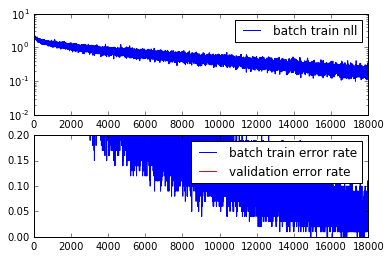

In [250]:
print("Setting network parameters from after epoch %d" %(best_params_epoch))
load_parameters(best_params)

print("Test error rate is %f%%" %(compute_error_rate(cifar_test_stream)*100.0,))

subplot(2,1,1)
train_nll_a = np.array(train_nll)
semilogy(train_nll_a[:,0], train_nll_a[:,1], label='batch train nll')
legend()

subplot(2,1,2)
train_erros_a = np.array(train_erros)
plot(train_erros_a[:,0], train_erros_a[:,1], label='batch train error rate')
validation_errors_a = np.array(validation_errors)
plot(validation_errors_a[:,0], validation_errors_a[:,1], label='validation error rate', color='r')
ylim(0,0.2)
legend()

In [ ]:
#How do the filters in the first layer look like?

plot_mat(CW1.get_value(), cmap='gray')

In [ ]:
iii = predict.maker.inputs[0]
X = iii.variable

In [ ]:
# build a function that shows how the network processes an image

middle_layers_computer = theano.function([X], [
        X,
        after_C1,
        after_P1,
        after_C2,
        after_P2
        ])


In [ ]:
img_num=4

middle_layers = middle_layers_computer(X_test_value[img_num:img_num+1])

for ml, name in zip(middle_layers, ['X', 'C1', 'P1', 'C2', 'P2']):
    plot_mat(ml.transpose(1,0,2,3), cmap='gray')
    title(name)
    show()